## Méthode de tir pour résoudre le système d’optimalité (Eq. 10), en dimension 1

**But.** Pour $A\in\mathbb{R}$, $G\in\mathbb{R}$, $C\in\mathbb{R}$, et $q_1,q_2>0$ des pondérations, construire le couple optimal
\begin{aligned}
h^\star(t) &= -\tfrac{1}{q_2} G_2^\top p(t),\\
z(0) &= -\tfrac{1}{q_1} p(0)
\end{aligned}
où $(z,p)$ est solution du système d’optimalité donné par le TPBVP:
\begin{aligned}
z'(t) &= A z(t) + G h^\star(t) = A z(t) - \tfrac{1}{q_2} G G^\top p(t), \quad z(0) = -\tfrac{1}{q_1} s,\\
p'(t) &= -A^\top p(t) - C^\top\!\big(C z(t) - y^{\mathrm m}(t)\big), \quad p(T)=0,
\end{aligned}
et $s := p(0)\in\mathbb{R}^n$ est **l’inconnue de tir**. 

---

### Principe de résolution par tir exact (pseudo-code)
1. Give input data 
    - System: A, G2, C
    - Objective: z0, h as known
    - Time discretization: T, N
    - Regulations: q1, q2
2. Forward z_true and y_m from known z0 and h
    - Integrate $z'(t) = A z(t) + G2 h(t)$ using RK4 over grid t
    - Then compute $Y(t) = C z(t)$
3. Backward p and z from y_m with shooting method on p(0)
    - Define a function that integrate $(z'(t), p'(t))$ with $z(0) = -s/q1$, $p(T) = 0$ under the shoot $s=p(0)$.
    - Define the shooting function $F(s) := p(T; s)$ and find the good $s^\star$ such that $F(s^\star)=0$ by multiple integrations with $s$.
    - Integrate final (z, p) with the good $s^\star$.
4. Reconstruction of the irrigation h
    - $h(t) = -(1/q2) * G2^T p(t)$
    - $z(0) = -(1/q1) * p(0)$
5. Make plots and metrics
    - Metrics: 
        - $z_0 - z_0estimated$
        - $RMSE_z = \sqrt{mean((z_{true} - z_{estimated})^2)}$
        - $RMSE_h = \sqrt{mean((z_{true} - z_{estimated})^2)}$
        - $Y Misfit = \int_0^T \|Cz(t)-y^m(t)\|^2 dt$
        - $H Energy = \int_0^T \|h(t)\|^2 dt$
    - Plots:
        - $z_{true}$ vs $z_{estimated}$
        - $h_{true}$ vs $h_{estimated}$
        - $z_{estimated}$ as function of q2
        - $h_{estimated}$ as function of q2
        - $RMSE_z$ as function of q2
        - $RMSE_h$ as function of q2
        - $Y Misfit$ as function of q2
        - $H Energy$ as function of q2

---

### Input example
- System: A=2, G2=3, C=4.9
- Objective: z0=4, h(t)=t(1 - t)
- Time discretization: T=1, N=200
- Regulations: q1=1, q2=1

---

### Ouput example (metrics)
z0 true = 4, z0 estimated = 2.617, error = 1.383<br>
RMSE(z) = 10.881<br>
RMSE(h) = 1.430<br>
Y Misfit = 1.466<br>
h Energy = 2.108

In [1]:
# Importations des modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
# Step 1 : Data input
# System parameters
n = 1
A = 2
G2 = 3
C = 4.9

# Objective
z0 = 4                      # supposed know
h = lambda t : t * (1 - t)  # supposed know


# Regulation parameters
q1 = 1
q2 = 1

# Time discretization
T = 1
N = 200
dt = T / N
t  = np.linspace(0, T, N+1)

In [3]:
# Step 2: Forward z_true and y_m from z0 and h known
def forward_z_from_h(z0, h):
    """Integrate z'(t) = A z(t) + G2(t) h(t) using RK4 over grid t
    Then compute Y(t) = C z(t)"""
    z = np.zeros_like(t); z[0] = z0
    for k in range(N):
        zk = z[k]; hk, hk_1 = h[k], h[k+1]
        h_mid = (hk + hk_1) / 2.0
        fz = lambda zz, hh : A*zz + G2*hh
        k1 = fz(zk,                hk)
        k2 = fz(zk+dt*k1/2.0,      h_mid)
        k3 = fz(zk+dt*k2/2.0,      h_mid)
        k4 = fz(zk+dt*k3,          hk_1)
        z[k+1] = zk + dt * (k1 + 2*k2 + 2*k3 + k4) / 6.0
    return z

h_true = h(t)
z_true = forward_z_from_h(z0, h_true)
y_m = C * z_true

In [4]:
df = pd.DataFrame({"t": t, 'h_true': h_true, 'z_true': z_true, 'y_m': y_m})
display(df)

,t,h_true,z_true,y_m
0,0.000,0.000000,4.000000,19.600000
1,0.005,0.004975,4.040238,19.797167
2,0.010,0.009900,4.080955,19.996681
3,0.015,0.014775,4.122155,20.198562
4,0.020,0.019600,4.163843,20.402830
...,...,...,...,...
196,0.980,0.019600,29.837870,146.205564
197,0.985,0.014775,30.138005,147.676224
198,0.990,0.009900,30.441083,149.161306
199,0.995,0.004975,30.747133,150.660952


In [5]:
# Step 3: Backward p and z from y_m with shooting method on p(0)
def backward_z_p_by_shooting(s, y_meas, q1=1.0, q2=1.0):
    """Integrate Z'(t) = A z(t) - (1/q2) G2 G2^T p(t)
        p'(t) = -A^T p(t) - C^T (C z(t) - y^m(t))
        z(0) = -s/q1, p(T) = 0 with s=p(0)
        s : vector (m,)
        y_meas : numpy array (N+1, m) containing y^m(t_k)
    """
    z = - (1.0 / q1) * s.copy()
    p = s.copy()

    traj_z = np.zeros((N+1, 1))
    traj_p = np.zeros((N+1, 1))
    traj_z[0] = z
    traj_p[0] = p

    G2G2T = G2 * G2 # G2T=G2 in n=1
    AT = A          # AT=A in n=1
    CT = C          # CT=C in n=1

    for k in range(N):
        yk = y_meas[k]  # y^m(t_k)

        # z' = A z - (1/q2) G2 G2^T p
        zdot = A * z - (1.0 / q2) * (G2G2T * p)

        # p' = -A^T p - C^T (C z - y^m)
        Cz_minus_y = C * z - yk
        pdot = - AT * p - CT * Cz_minus_y

        # Euler
        z = z + dt * zdot
        p = p + dt * pdot

        traj_z[k+1] = z
        traj_p[k+1] = p

    pT = p  # p at final time, i.e. p(T; s)
    return pT, traj_z, traj_p


# Shooting function
def F_of_s(s, y_meas, q1=1.0, q2=1.0):
    """Return F(s) = P(T; s)"""
    pT, _, _ = backward_z_p_by_shooting(s, y_meas, q1, q2)
    return pT


# Finding of good s by secant on p(T; s)=0
def find_s_star(y_meas, q1=1.0, q2=1.0, s0=0.0, s1=1.0, tol=1e-6, maxit=20):
    """Resolve F(s)=P(T;s)=0 by secant method.
    s0, s1 : initial points for s"""
    F0 = F_of_s(np.array([s0]), y_meas, q1, q2)[0]
    F1 = F_of_s(np.array([s1]), y_meas, q1, q2)[0]

    for _ in range(maxit):
        if abs(F1 - F0) < 1e-12:
            break
        s2 = s1 - F1 * (s1 - s0) / (F1 - F0)
        F2 = F_of_s(np.array([s2]), y_meas, q1, q2)[0]
        if abs(F2) < tol:
            return s2
        s0, F0 = s1, F1
        s1, F1 = s2, F2

    return s1  # approx


# Finding final (z,p) from shooting
def find_z_p(y_meas, q1=1.0, q2=1.0):
    s_star = find_s_star(y_meas, q1, q2)
    return backward_z_p_by_shooting(s_star, y_meas, q1, q2)


In [12]:
# Step 4: Reconstruction of the irrigation h
def reconstruction(y_meas, q1=1.0, q2=1.0):
    """Return h*() from (z,p), solution of the TPBVP:
        h(t) = -(1/q2) * G2^T p(t)
        z(0) = -(1/q1) * p(0)
    """
    _, traj_z, traj_p = find_z_p(y_meas, q1, q2)
    z0 = -traj_p[0][0] / q1 # already in traj_z

    traj_h = np.zeros((N+1, 1))
    for k in range(N+1):
        traj_h[k] = - (1.0 / q2) * (G2 * traj_p[k])  # G2T=G2 in n=1
    
    return z0, traj_z, traj_h

z0_est, z_est, h_est = reconstruction(y_m)

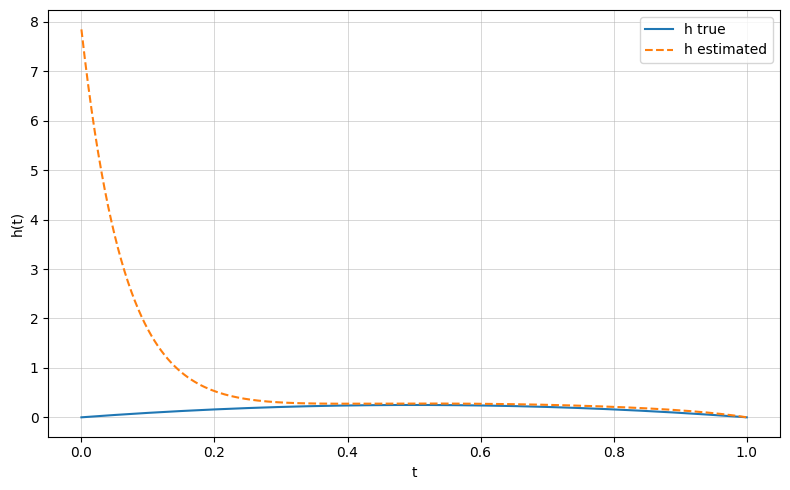

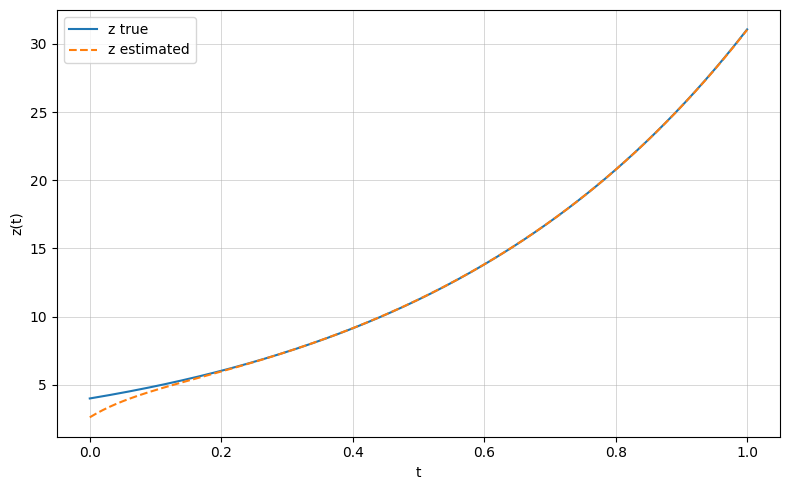

In [13]:
# Step 5: quick plots
import matplotlib.pyplot as plt
import os

outdir = "figs"
"""Create directory if it does not exist."""
os.makedirs(outdir, exist_ok=True)

plt.figure(figsize=(8, 5)); plt.plot(t, h_true, label="h true"); plt.plot(t, h_est, "--", label="h estimated"); plt.legend(); plt.xlabel("t"); plt.ylabel("h(t)"); plt.grid(alpha=0.7, linewidth=0.5); plt.tight_layout()
plt.savefig(os.path.join(outdir, "fig_n1_h_true_vs_h_estimated.png"), dpi=200)
plt.figure(figsize=(8, 5)); plt.plot(t, z_true, label="z true"); plt.plot(t, z_est, "--", label="z estimated"); plt.legend(); plt.xlabel("t"); plt.ylabel("z(t)"); plt.grid(alpha=0.7, linewidth=0.5); plt.tight_layout()
plt.savefig(os.path.join(outdir, "fig_n1_z_true_vs_z_estimated.png"), dpi=200)
plt.show()

In [8]:
# Metrics
z0_error = np.abs(z0_est - z0)
z_rmse = np.sqrt(np.mean((z_est - z_true)**2))
h_rmse = np.sqrt(np.mean((h_est - h_true)**2))
misfit = np.trapz((C*z_est[:, 0] - y_m)**2, t)  #because z_est is (N+1, 1)
energy = np.trapz(h_est[:, 0]**2, t)            #because h_est is (N+1, 1)


print("===== Résultats =====")
print(f"z0 true = {z0}, z0 estimated = {z0_est:.3f}, error = {z0_error:.3f}")
print(f"RMSE(z) = {z_rmse:.3f}")
print(f"RMSE(h) = {h_rmse:.3f}")
print(f"Misfit = {misfit:.3f}")
print(f"Energy = {energy:.3f}")

===== Résultats =====
z0 true = 4, z0 estimated = 2.617, error = 1.383
RMSE(z) = 10.881
RMSE(h) = 1.430
Misfit = 1.466
Energy = 2.108


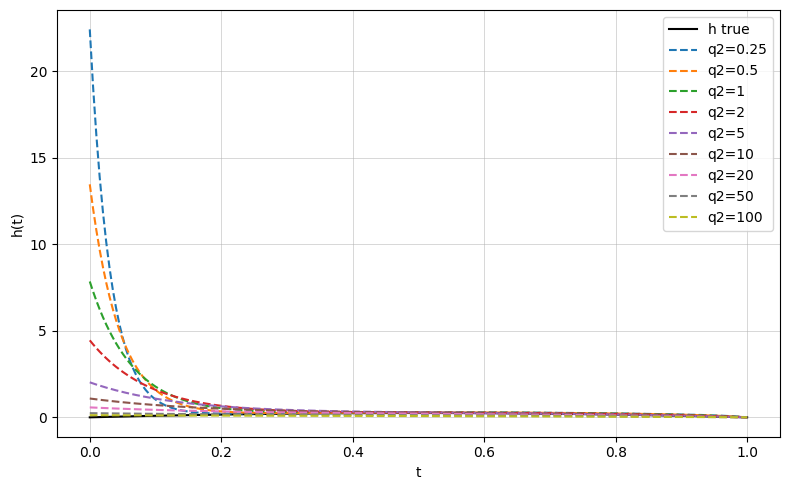

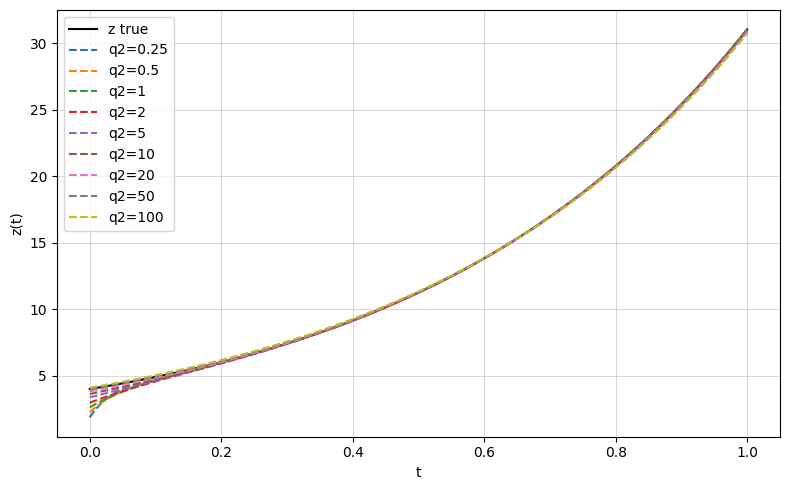

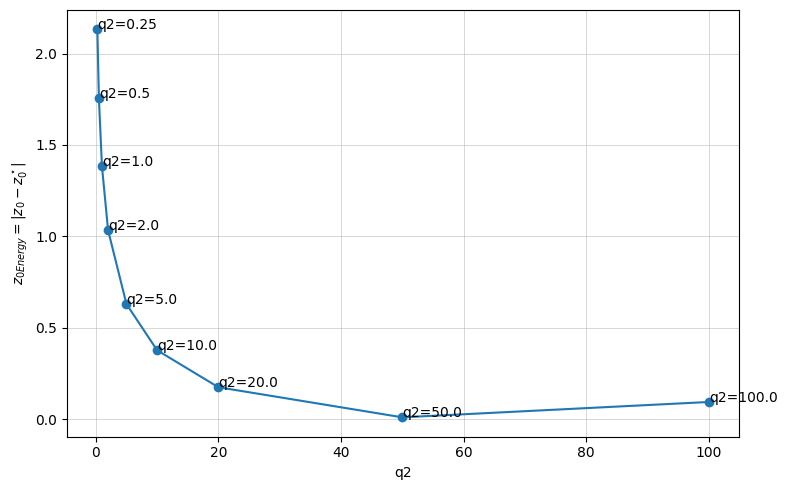

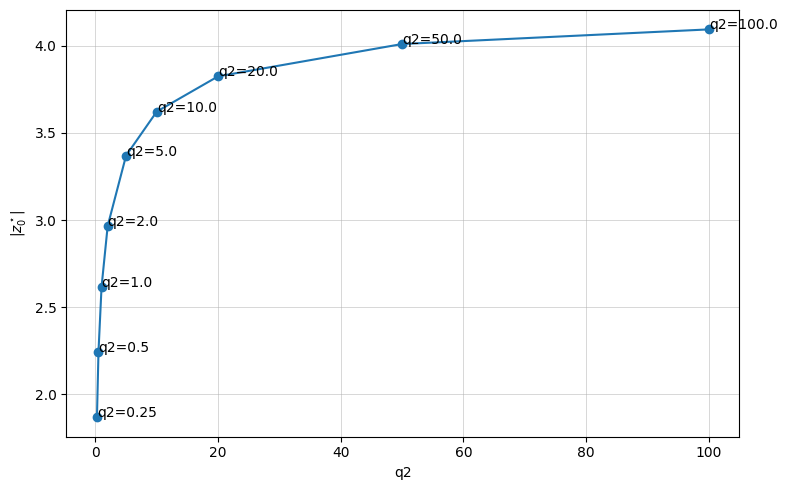

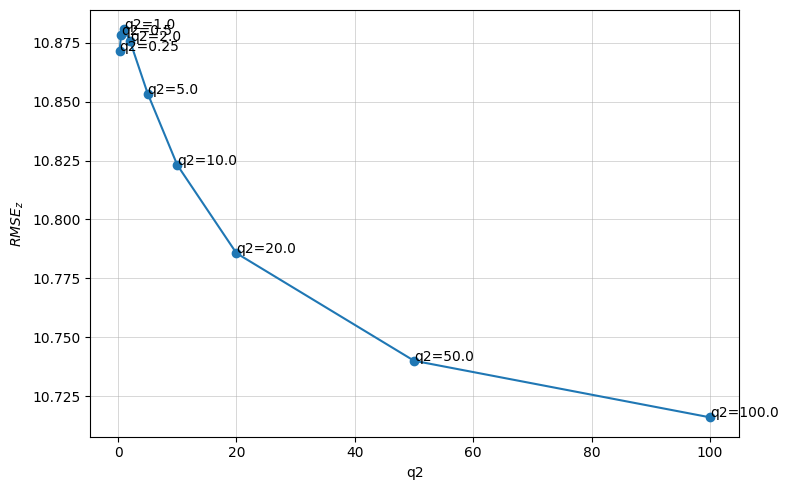

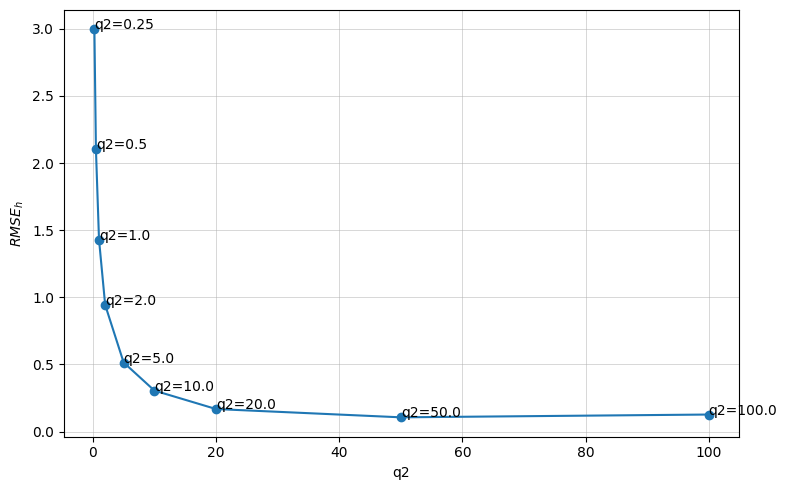

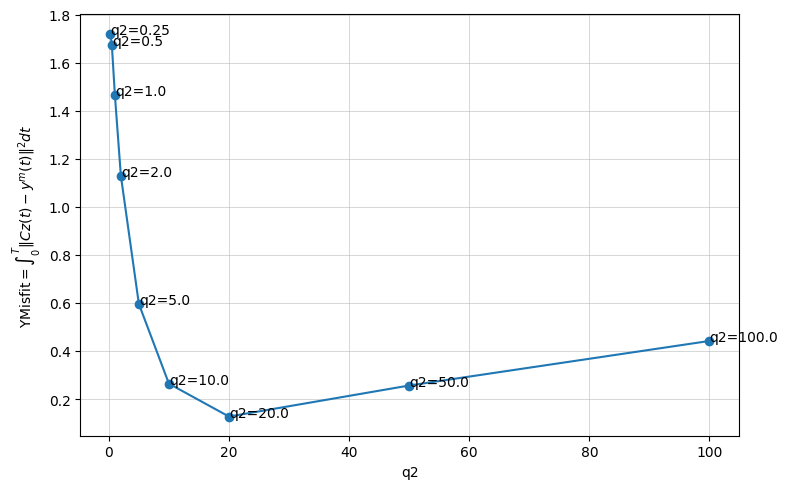

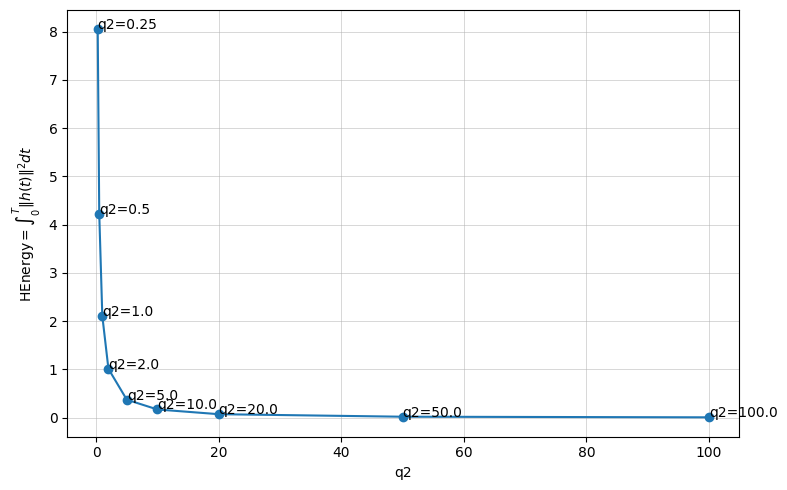

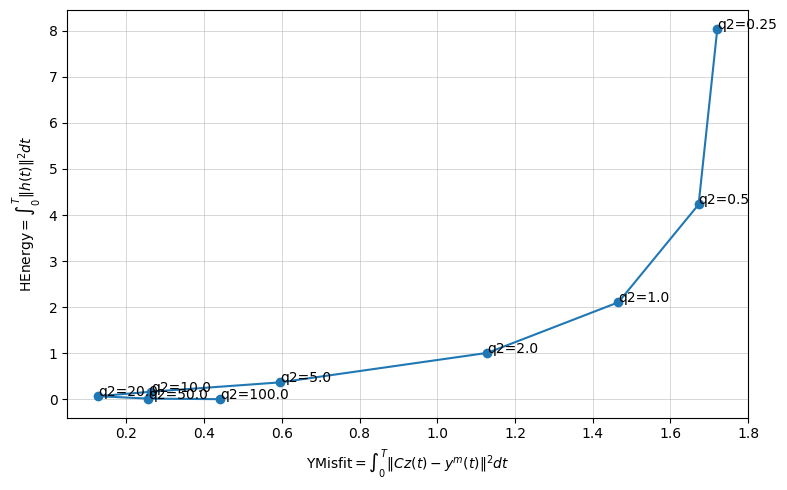

In [9]:
# Sensibility of q2: sweep q2, compute solutions & metrics
q1 = 1.0
#q2_list = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]
q2_list = [0.25, 0.5, 1, 2, 5, 10, 20, 50, 100]
#q2_list = [0.25, 0.5, 1.0, 2.0, 5.0, 10.0]

curves_z, curves_h, metrics = [], [], []
for q2 in q2_list:
    z0_est, z_est, h_est = reconstruction(y_m, q1, q2)
    z0_error = np.abs(z0_est - z0)
    z0_energy = np.linalg.norm(z0_est)
    z_rmse = np.sqrt(np.mean((z_est - z_true)**2))
    h_rmse = np.sqrt(np.mean((h_est - h_true)**2))
    misfit = np.trapz((C*z_est[:, 0] - y_m)**2, t)  #because z_est is (N+1, 1)
    energy = np.trapz(h_est[:, 0]**2, t)            #because h_est is (N+1, 1)
    misfit_energy = misfit - energy
    
    curves_z.append(z_est)
    curves_h.append(h_est)
    metrics.append({
        "q2": q2,
        "z0_error": z0_error,
        "z0_energy": z0_energy,
        "z_rmse": z_rmse,
        "h_rmse": h_rmse,
        "misfit": misfit,
        "energy": energy,
        "misfit_energy": misfit_energy
    })
metrics = pd.DataFrame(metrics).sort_values("q2").reset_index(drop=True)

# Figures (overlays & curves)
plt.figure(figsize=(8, 5))
plt.plot(t, h_true, "k-", label=f"h true")
for i, q2 in enumerate(q2_list):
    plt.plot(t, curves_h[i], "--", label=f"q2={q2}")
plt.xlabel("t"); plt.ylabel("h(t)")
# plt.title("Sensibility in q2 of h")
plt.grid(alpha=0.7, linewidth=0.5)
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(outdir, "fig_n1_h_q2_sensibility.png"), dpi=200); #plt.close()

plt.figure(figsize=(8, 5))
plt.plot(t, z_true, "k-", label=f"z true")
for i, q2 in enumerate(q2_list):
    plt.plot(t, curves_z[i], "--", label=f"q2={q2}")
plt.xlabel("t"); plt.ylabel("z(t)")
# plt.title("Sensibility in q2 of z")
plt.grid(alpha=0.7, linewidth=0.5)
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(outdir, "fig_n1_z_q2_sensibility.png"), dpi=200); #plt.close()

plt.figure(figsize=(8, 5))
plt.plot(metrics["q2"], metrics["z0_error"], marker="o")
for i, row in metrics.iterrows():
    plt.annotate(f"q2={row['q2']}", (row["q2"], row["z0_error"]))
plt.grid(alpha=0.7, linewidth=0.5)
plt.xlabel("q2"); plt.ylabel(r"$z_{0Energy}=|z_0 - z_0^\star|$")
# plt.title(r"Error of $z_0$")
plt.tight_layout()
plt.savefig(os.path.join(outdir, "fig_n1_z0_error.png"), dpi=200); #plt.close()

plt.figure(figsize=(8, 5))
plt.plot(metrics["q2"], metrics["z0_energy"], marker="o")
for i, row in metrics.iterrows():
    plt.annotate(f"q2={row['q2']}", (row["q2"], row["z0_energy"]))
plt.grid(alpha=0.7, linewidth=0.5)
plt.xlabel("q2"); plt.ylabel(r"$|z_0^\star|$")
# plt.title(r"Energy of $z_0$")
plt.tight_layout()
plt.savefig(os.path.join(outdir, "fig_n1_z0_energy.png"), dpi=200); #plt.close()

plt.figure(figsize=(8, 5))
plt.plot(metrics["q2"], metrics["z_rmse"], marker="o")
for i, row in metrics.iterrows():
    plt.annotate(f"q2={row['q2']}", (row["q2"], row["z_rmse"]))
plt.grid(alpha=0.7, linewidth=0.5)
plt.xlabel("q2"); plt.ylabel(r"$RMSE_z$")
# plt.title(r"$RMSE_z$")
plt.tight_layout()
plt.savefig(os.path.join(outdir, "fig_n1_z_rmse.png"), dpi=200); #plt.close()

plt.figure(figsize=(8, 5))
plt.plot(metrics["q2"], metrics["h_rmse"], marker="o")
for i, row in metrics.iterrows():
    plt.annotate(f"q2={row['q2']}", (row["q2"], row["h_rmse"]))
plt.grid(alpha=0.7, linewidth=0.5)
plt.xlabel("q2"); plt.ylabel(r"$RMSE_h$")
# plt.title(r"$RMSE_h$")
plt.tight_layout()
plt.savefig(os.path.join(outdir, "fig_n1_h_rmse.png"), dpi=200); #plt.close()

plt.figure(figsize=(8, 5))
plt.plot(metrics["q2"], metrics["misfit"], marker="o")
for i, row in metrics.iterrows():
    plt.annotate(f"q2={row['q2']}", (row["q2"], row["misfit"]))
plt.grid(alpha=0.7, linewidth=0.5)
plt.xlabel("q2"); plt.ylabel(r"$\mathrm{YMisfit}=\int_0^T\|Cz(t)-y^m(t)\|^2 dt$")
# plt.title("Y Misfit as function of q2")
plt.tight_layout()
plt.savefig(os.path.join(outdir, "fig_n1_misfit_q2_sensibility.png"), dpi=200); #plt.close()

plt.figure(figsize=(8, 5))
plt.plot(metrics["q2"], metrics["energy"], marker="o")
for i, row in metrics.iterrows():
    plt.annotate(f"q2={row['q2']}", (row["q2"], row["energy"]))
plt.grid(alpha=0.7, linewidth=0.5)
plt.xlabel("q2"); plt.ylabel(r"$\mathrm{HEnergy}=\int_0^T \|h(t)\|^2 dt$")
# plt.title("H energy as function of q2")
plt.tight_layout()
plt.savefig(os.path.join(outdir, "fig_n1_energy_q2_sensibility.png"), dpi=200); #plt.close()

plt.figure(figsize=(8, 5))
plt.plot(metrics["misfit"], metrics["energy"], marker="o")
for i, row in metrics.iterrows():
    plt.annotate(f"q2={row['q2']}", (row["misfit"], row["energy"]))
plt.grid(alpha=0.7, linewidth=0.5)
plt.xlabel(r"$\mathrm{YMisfit}=\int_0^T\|Cz(t)-y^m(t)\|^2 dt$")
plt.ylabel(r"$\mathrm{HEnergy}=\int_0^T \|h(t)\|^2 dt$")
# plt.title("Compromis YMisfit/HEnergy")
plt.tight_layout()
plt.savefig(os.path.join(outdir, "fig_n1_misfit_energy_q2_sensibility.png"), dpi=200); #plt.close()

plt.show()

In [10]:
metrics

,q2,z0_error,z0_energy,z_rmse,h_rmse,misfit,energy,misfit_energy
0,0.25,2.132053,1.867947,10.871347,2.995246,1.720703,8.047111,-6.326408
1,0.50,1.756188,2.243812,10.878243,2.100953,1.672484,4.229886,-2.557402
2,1.00,1.383427,2.616573,10.880672,1.430302,1.466105,2.108117,-0.642012
3,2.00,1.033683,2.966317,10.875838,0.943256,1.128972,1.010674,0.118298
4,5.00,0.629801,3.370199,10.853451,0.514575,0.595370,0.370692,0.224678
5,10.00,0.377284,3.622716,10.823105,0.305353,0.263966,0.168408,0.095558
6,20.00,0.175019,3.824981,10.785681,0.168107,0.127066,0.070809,0.056257
7,50.00,0.010499,4.010499,10.740029,0.106328,0.256310,0.018436,0.237873
8,100.00,0.094417,4.094417,10.716010,0.127116,0.441740,0.005721,0.436019
